<hr style="border:none;height:6px;background:#fff;margin:1em 0;">


<div style="text-align: center;">
  <h1>Dividend Taxation and Top-Income Inequality</h1>
  <h3>HEC Liege</h3>
  <h4><em>Lucas Dubois</em></h4>
</div>

<hr style="border:none;height:6px;background:#fff;margin:1em 0;">


<hr style="border:none;height:4px;background:#fff;margin:1em 0;">


In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.stats import diagnostic
from statsmodels.stats.sandwich_covariance import cov_hac
from statsmodels.stats.sandwich_covariance import se_cov
from stargazer.stargazer import Stargazer
import warnings
import re

path = '/Users/lucasdubois/Desktop/MASTERDATA/' 

<hr style="border:none;height:4px;background:#fff;margin:1em 0;">


<div style="text-align: align;">
  <h2> <small>1</small>&nbsp;&nbsp;&nbsp;&nbsp;Database:</h2>
</div>

<hr style="border:none; border-top:2px dashed #fff; margin:1em 0;">








<div style="text-align: align;">
  <h3> <small>1.1</small>&nbsp;&nbsp;&nbsp;&nbsp;Extracting:</h3>
</div>

In order to realize this research, I will construct a database by combining several available databases. Firstly, I will start the database by adding the [WID](https://wid.world/)'s data for top income inequality as well as the top wealth . The [WID](https://wid.world/) provides data for both the 1st and the 10th percentiles, and will have both. This, hopefully, will allow us to obtain various results we can make sense of.

In [23]:
df1 = pd.read_csv(path + 'WID_income_inequality4.csv', sep=';', skiprows=1, engine='python')
df1.columns = df1.columns.str.strip()

def extract_country(col: str) -> str:
    parts = col.split("\n")
    return parts[-1].strip()

rename_map = {}
for col in df1.columns:
    if isinstance(col, str) and col.startswith("sptinc_z_"):
        rename_map[col] = extract_country(col) + "_inc"
    elif isinstance(col, str) and col.startswith("shweal_z_"):
        rename_map[col] = extract_country(col) + "_w"

df1 = df1.rename(columns=rename_map)

df_long = df1.melt(
    id_vars=['Percentile', 'Year'],
    var_name='CountryVar',
    value_name='Value'
)

tmp = df_long['CountryVar'].str.rsplit('_', n=1, expand=True)
df_long['Country Name'] = tmp[0]
df_long['kind'] = tmp[1]  

df_long = df_long[df_long['Percentile'].isin(['p99p100', 'p90p100'])]

pct_map = {'p99p100': 'top1', 'p90p100': 'top10'}
df_long['var'] = df_long['Percentile'].map(pct_map) + '_' + df_long['kind']

df1 = (df_long
           .pivot_table(index=['Year', 'Country Name'], columns='var', values='Value', aggfunc='mean')
           .reset_index()
           .sort_values(['Country Name', 'Year'])
           .reset_index(drop=True)
           .round(4))

df1.head()

var,Year,Country Name,top10_inc,top10_w,top1_inc,top1_w
0,1980,Afghanistan,0.4095,NaN,0.1583,NaN
1,1981,Afghanistan,0.4095,NaN,0.1583,NaN
2,1982,Afghanistan,0.4095,NaN,0.1583,NaN
3,1983,Afghanistan,0.4095,NaN,0.1583,NaN
4,1984,Afghanistan,0.4095,NaN,0.1583,NaN


In [24]:
df1.to_csv("/Users/lucasdubois/Desktop/MASTERDATA/Final_WID.csv", index=False)

The paper by Roine et al., [2009](https://doi.org/10.1016/j.jpubeco.2009.04.003) provides several empirical insights regarding the long-run determinants of top-income inequality. Their approach (FDGLS and DFD) is nothing short of similar to ours, thus making their contribuition particularly interesting. I intend to add their results as controls in my endeavor, in order to add more information to the models and hopefuly improve it. Note nonetheless that the long-run nature of this project and the sample (mostly developed countries) might render some controls not significant or of magnitude in the model, but that we can only know when trying.
From their results, the authors find the following determinants to be statistically significant:

- Financial Development (total capitalization as a sum of bank deposits and market cap.)  (+)
- Income per capita (GDP per capita) (+)
- Marginal taxes (-)

We can then include several variables from the [World Bank Group](https://databank.worldbank.org) Databank in order to improve our model and reducing the chances of encountering endogeneity issues:

In [27]:
years = list(range(1995, 2024))

columns = ["Country Name", "Country Code", "Series Name", "Series Code"] + years

df_raw = pd.read_csv(
    path + 'World_Bank1.csv',
    sep=',',
    names=columns,
    engine='python',
    encoding='utf-8',
    skiprows=0,
    on_bad_lines='skip'
)

df_long = df_raw.melt(
    id_vars=["Country Name", "Country Code", "Series Name", "Series Code"],
    var_name="Year",
    value_name="Value"
)

df_long["Year"] = df_long["Year"].astype(int)

df_long["Value"] = pd.to_numeric(df_long["Value"], errors="coerce")  

df_pivot = df_long.pivot_table(
    index=["Country Name", "Year"],
    columns="Series Code",
    values="Value"
).reset_index()

df_pivot = df_pivot.rename(columns={
    "NW.DOW.PC.CD": "domestic_wealth_pc",
    "NW.NFA.PC.CD": "foreign_assets_pc",
    "NW.NFL.PC.CD": "foreign_liabilities_pc",
    "NW.HCA.PC.CD": "human_capital_pc",
    "NW.TOW.TO.CD": "national_wealth_total",
    "NW.DOW.TO.CD": "domestic_wealth_total"
})

df_pivot = df_pivot.sort_values(["Country Name", "Year"]).reset_index(drop=True)

df2 = df_pivot.round(2)

df2.head()


Series Code,Country Name,Year,domestic_wealth_pc,domestic_wealth_total,human_capital_pc,foreign_assets_pc,foreign_liabilities_pc,national_wealth_total
0,Albania,1995,10150.35,3.235712e+10,4257.13,163.44,194.81,3.225712e+10
1,Albania,1996,12135.21,3.844475e+10,4950.64,208.96,231.69,3.837275e+10
2,Albania,1997,10135.05,3.190797e+10,3446.47,195.34,250.30,3.173497e+10
3,Albania,1998,11211.24,3.507471e+10,3739.96,249.00,310.69,3.488171e+10
4,Albania,1999,12807.14,3.981456e+10,4502.05,315.56,372.82,3.963656e+10


In [28]:
df2.to_csv("/Users/lucasdubois/Desktop/MASTERDATA/Final_WB1.csv", index=False)

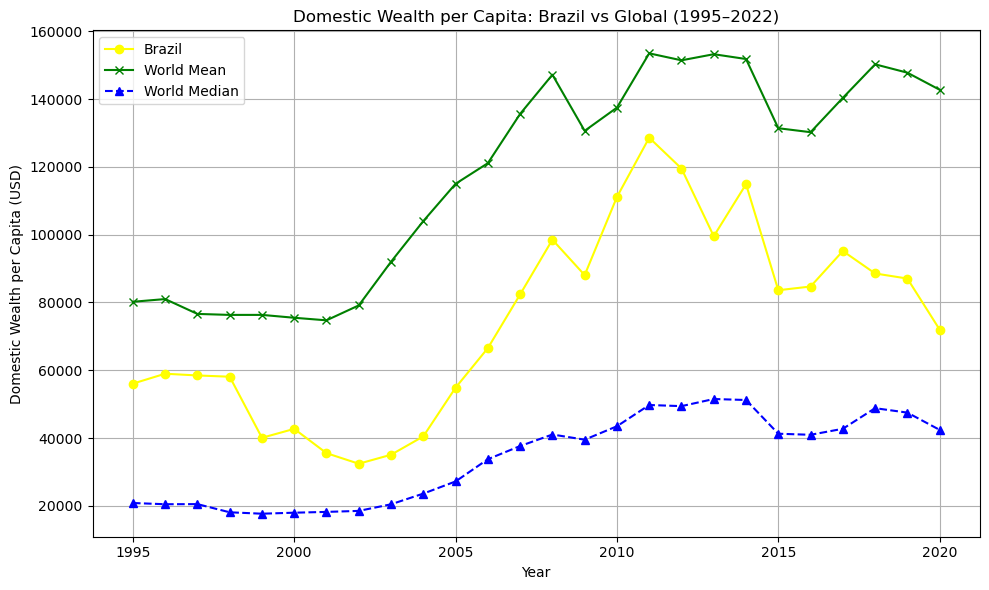

In [29]:
years = list(range(1995, 2023))

df_filtered = df_pivot[df_pivot['Year'].isin(years)]

world_mean = df_filtered.groupby('Year')['domestic_wealth_pc'].mean()

world_median = df_filtered.groupby('Year')['domestic_wealth_pc'].median()

brazil_data = df_filtered[df_filtered['Country Name'] == 'Brazil'].set_index('Year')['domestic_wealth_pc']

plt.figure(figsize=(10, 6))
plt.plot(brazil_data.index, brazil_data.values, marker='o', label='Brazil', color="yellow")
plt.plot(world_mean.index, world_mean.values, marker='x', label='World Mean',color="green")
plt.plot(world_median.index, world_median.values, marker='^', label='World Median', linestyle='--',color="blue")

plt.title('Domestic Wealth per Capita: Brazil vs Global (1995–2022)')
plt.xlabel('Year')
plt.ylabel('Domestic Wealth per Capita (USD)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


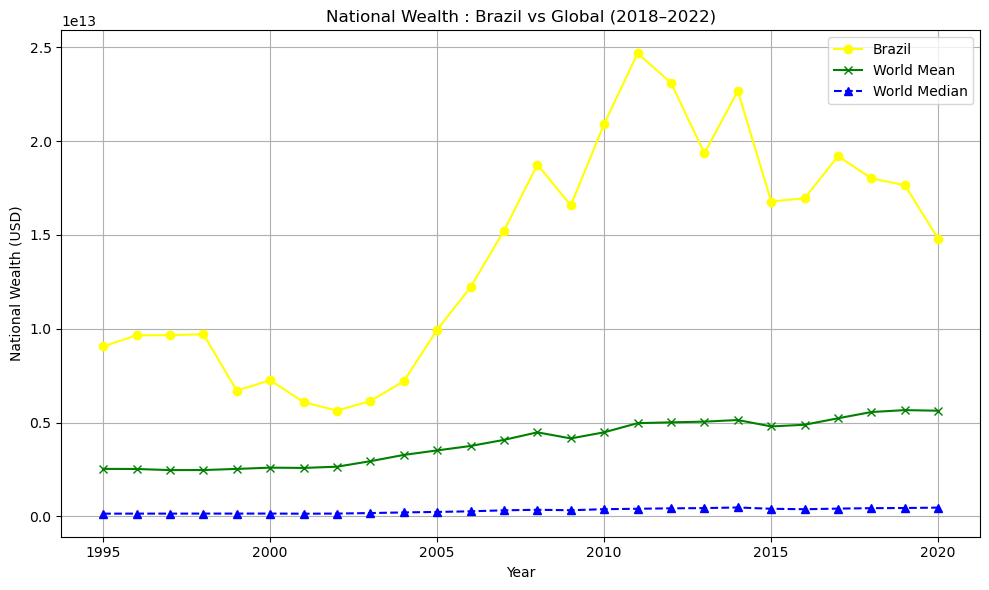

In [30]:
years = list(range(1995, 2023))

df_filtered = df_pivot[df_pivot['Year'].isin(years)]

world_mean = df_filtered.groupby('Year')['national_wealth_total'].mean()

world_median = df_filtered.groupby('Year')['national_wealth_total'].median()

brazil_data = df_filtered[df_filtered['Country Name'] == 'Brazil'].set_index('Year')['national_wealth_total']

plt.figure(figsize=(10, 6))
plt.plot(brazil_data.index, brazil_data.values, marker='o', label='Brazil', color="yellow")
plt.plot(world_mean.index, world_mean.values, marker='x', label='World Mean',color="green")
plt.plot(world_median.index, world_median.values, marker='^', label='World Median', linestyle='--', color="blue")

plt.title('National Wealth : Brazil vs Global (2018–2022)')
plt.xlabel('Year')
plt.ylabel('National Wealth (USD)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [35]:
file = path + "World_Bank2.csv"

with open(file, "r", encoding="utf-8") as f:
    lines = f.readlines()

header_row = None
for i, line in enumerate(lines[:50]): 
    if "Country Name" in line and "Country Code" in line:
        header_row = i
        break

if header_row is None:
    header_row = 0

df_raw1 = pd.read_csv(
    file,
    sep=",",                
    header=header_row,       
    engine="python",
    encoding="utf-8",
    on_bad_lines="skip"
)

df_raw1.columns = df_raw1.columns.astype(str).str.strip()

rename_meta = {
    "Indicator Name": "Series Name",
    "Indicator Code": "Series Code"
}
df_raw1 = df_raw1.rename(columns=rename_meta)

required = ["Country Name", "Country Code", "Series Name", "Series Code"]
missing = [c for c in required if c not in df_raw1.columns]
if missing:
    raise ValueError(f"Missing required columns: {missing}. "
                     f"Available columns: {list(df_raw1.columns)}")

def is_year(col):
    col = str(col)
    return bool(re.fullmatch(r"\d{4}", col)) or bool(re.fullmatch(r"\d{4}\s*\[YR\d{4}\]", col))

year_cols = [c for c in df_raw1.columns if is_year(c)]

year_rename = {}
for c in year_cols:
    m = re.search(r"(\d{4})", str(c))
    if m:
        year_rename[c] = m.group(1)
if year_rename:
    df_raw1 = df_raw1.rename(columns=year_rename)
    year_cols = [year_rename.get(c, c) for c in year_cols]  # normalized

df_long1 = df_raw1.melt(
    id_vars=["Country Name", "Country Code", "Series Name", "Series Code"],
    value_vars=year_cols,
    var_name="Year",
    value_name="Value"
)

df_long1["Year"] = pd.to_numeric(df_long1["Year"], errors="coerce").astype("Int64")
df_long1["Value"] = pd.to_numeric(df_long1["Value"], errors="coerce")

df_long1 = df_long1.dropna(subset=["Year"]).astype({"Year": "int64"})

df_3 = df_long1.pivot_table(
    index=["Country Name", "Year"],
    columns="Series Code",
    values="Value",
    aggfunc="mean"  
).reset_index()

df_3 = df_3.rename(columns={
    "NY.GDP.PCAP.CD": "gdp_per_cap",
    "HD.HCI.OVRL": "human_capital_index",
    "FP.CPI.TOTL.ZG": "inflation",
    "FR.INR.LNDP": "interest_rate_pct_rev",  
    "GC.XPN.INTP.RV.ZS": "interest_rate_spread",
    "SE.SEC.CUAT.LO.MA.ZS": "educational_attainment",
    "SL.UEM.TOTL.NE.ZS": "unemployment"
})

df_3 = df_3.sort_values(["Country Name", "Year"]).reset_index(drop=True)
df3 = df_3.round(2)

print(df_3.head())
print(df_3.columns.tolist()[:12])

Series Code Country Name  Year  inflation  interest_rate_pct_rev  \
0            Afghanistan  1975        NaN                    NaN   
1            Afghanistan  1979        NaN                    NaN   
2            Afghanistan  2000        NaN                    NaN   
3            Afghanistan  2001        NaN                    NaN   
4            Afghanistan  2002        NaN                    NaN   

Series Code  interest_rate_spread  human_capital_index  gdp_per_cap  \
0                             NaN                  NaN          NaN   
1                             NaN                  NaN          NaN   
2                             NaN                  NaN   174.930991   
3                             NaN                  NaN   138.706822   
4                             NaN                  NaN   178.954088   

Series Code  educational_attainment  unemployment  
0                              6.31           NaN  
1                              7.45           NaN  
2       

In [ ]:
df3.to_csv("/Users/lucasdubois/Desktop/MASTERDATA/Final_WB2.csv", index=False)

<hr style="border:none; border-top:2px dashed #fff; margin:1em 0;">


<div style="text-align: align;">
  <h3> <small>1.2</small>&nbsp;&nbsp;&nbsp;&nbsp;Merging:</h3>
</div>

Now we need to merge our four datasets in order to have a final workable dataset in which we can work.

In [ ]:
merged1 = pd.merge(df1, df2, on=["Country Name", "Year"], how="outer")

MASTER_FINAL = pd.merge(merged1, df3, on=["Country Name", "Year"], how="outer")

MASTER_FINAL= MASTER_FINAL.sort_values(["Country Name", "Year"]).reset_index(drop=True)
MASTER_FINAL = MASTER_FINAL.round(4)

print(MASTER_FINAL.shape)
MASTER_FINAL.head()

Now, that we've merged our three databases in order to create a final one, we have a total of 17 variables, for each year and country, namely:

- _top10_inc_: Pre-tax national income share of the 10% top income earners.
- _top1_inc_: Pre-tax national income share of the 1% top income earners.
- _top10_w_: Net personal wealth of equally split adults, top 10%.
- _top10_w_: Net personal wealth of equally split adults, top 10%.
- _domestic_wealth_pc_: Domestic comprehensive wealth index.
- _domestic_wealth_total_: Domestic comprehensive wealth index per capita.
- _human_capital_pc_: Human capital per capita
- _foreign_assets_pc_: Foreign assets per capita.
- _foreign_liabilities_pc_: Foreign liabilities per capita.
- _national_wealth_total_: National comprehensive wealth.
- _inflation_: Annual GDP deflator in %.
- _interest_rate_pct_rev_: Interest rates as a percentage of revenue.
- _interest_rate_spread_: Interest rate spread.
- _human_capital_index_: Human capital Index
- _gdp_per_cap_: GDP per capita.
- _educational_attainment_: School enrollment, secondary.
- _unemployment_: Total unemployment.


In [ ]:
MASTER_FINAL.to_csv("/Users/lucasdubois/Desktop/MASTERDATA/MASTER_FINAL.csv", index=False)

In [ ]:
dfaaa = pd.read_csv("/Users/lucasdubois/Desktop/MASTERDATA/MASTER_FINAL.csv")
n_obs = len(dfaaa)
n_obs = dfaaa.shape[0]

print("Number of observations:", n_obs)

I have a problem: USA and UNited states!!!!